In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [3]:
df_repeats, df_calls = file_io.dfs_from_vcf(
    filename="../../data/banana/variants/v0.9.0/SAMEA5752290_merged.vcf", 
    samples=["SAMEA5752290"], 
    vcf_format="ConSTRain"
)

subset = ["genotype", "frequencies"]
# subset = ["frequencies"]
df_calls = df_calls.dropna(subset=subset).assign(
    depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    depth_norm = lambda x: x["depth"] / x["copy_number"],
).reset_index(drop=True)

df_calls = df_calls.merge(df_repeats[["str_id", "chr", "start", "end", "period"]], on="str_id")

df_repeats.shape, df_calls.shape

((183345, 7), (153167, 11))

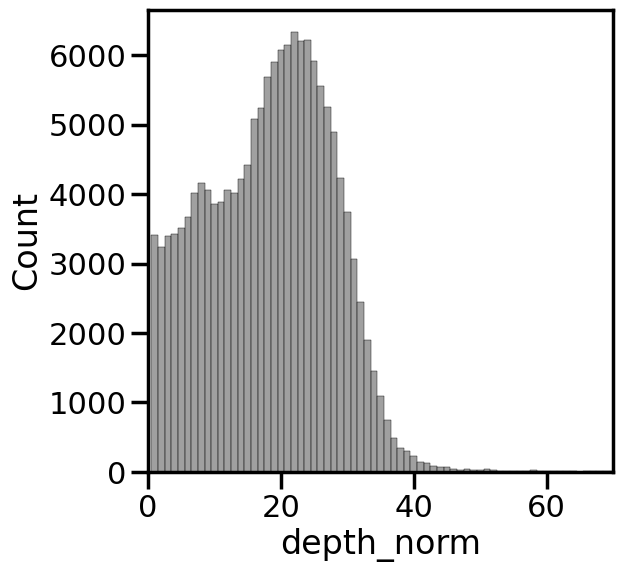

In [4]:
fig = plt.figure(figsize=(6, 6))

ax = sns.histplot(
    df_calls.query("depth_norm < 100"),
    x="depth_norm",
    discrete=True,
    color="grey"
)

_ = ax.set(
    xlim=(0, 70)
)

In [5]:
print(df_calls["depth_norm"].mean())

start, end = 28000000, 33750000
print(df_calls.query(f"chr == 'chr02' and start > {start} and end < {end}")["depth_norm"].shape)
print(df_calls.query(f"chr == 'chr02' and start > {start} and end < {end}")["depth_norm"].mean())

df_calls = df_calls.assign(in_dup = lambda x: np.array((x["chr"] == "chr02") & (x["start"] > start) & (x["end"] < end)))
df_calls.head()

18.990840063460144
(2703,)
27.29399432729066


,sample,str_id,copy_number,frequencies,genotype,depth,depth_norm,chr,start,end,period,in_dup
0,SAMEA5752290,chr01_22744,3,{3: 22},"[3, 3, 3]",22,7.333333,chr01,22744,22755,4,False
1,SAMEA5752290,chr01_33907,3,{3: 78},"[3, 3, 3]",78,26.000000,chr01,33907,33924,6,False
2,SAMEA5752290,chr01_35829,3,"{5: 15, 6: 4}","[5, 5, 6]",19,6.333333,chr01,35829,35842,2,False
3,SAMEA5752290,chr01_37881,3,{18: 3},"[18, 18, 18]",3,1.000000,chr01,37881,37930,2,False
4,SAMEA5752290,chr01_37997,3,{7: 8},"[7, 7, 7]",8,2.666667,chr01,37997,38046,2,False


In [6]:
lower, upper = 1.0, (34.0 + 2/3)
(df_calls
     .assign(in_range = lambda x: np.array((x["depth_norm"] >= lower) & (x["depth_norm"] < upper)))
     .groupby("in_dup", as_index=False)
     .value_counts(["in_range"], normalize=True)
)



,in_dup,in_range,proportion
0,False,True,0.975363
1,False,False,0.024637
2,True,True,0.729560
3,True,False,0.270440


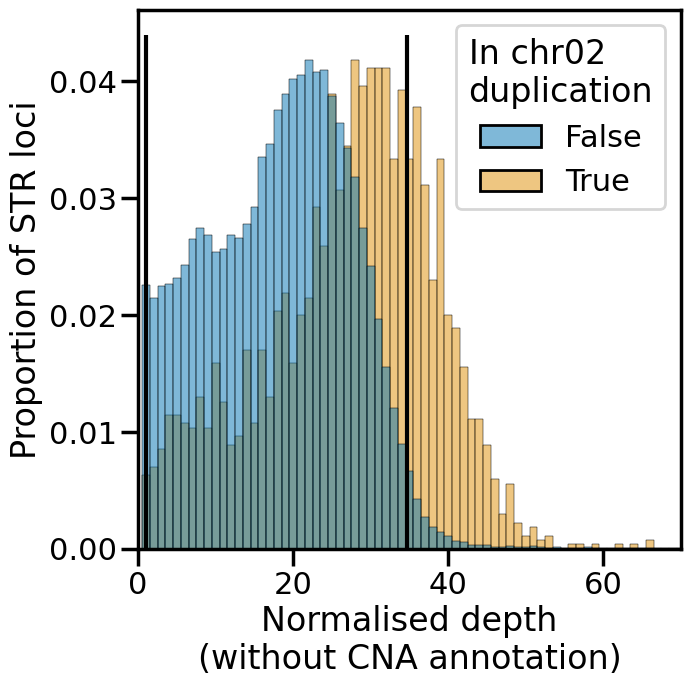

In [7]:
fig = plt.figure(figsize=(7, 7))

ax = sns.histplot(
    df_calls.query("depth_norm < 100"),
    x="depth_norm",
    hue="in_dup",
    palette="colorblind",
    discrete=True,
    stat="probability",
    common_norm=False
)

ax.vlines(x=[lower, upper], ymin=0, ymax=ax.get_ylim()[1], color="black")

_ = ax.set(
    xlim=(0, 70),
    xlabel="Normalised depth\n(without CNA annotation)",
    ylabel="Proportion of STR loci"
)
_ = ax.get_legend().set(title="In chr02\nduplication")
plt.show()

In [8]:
# lower, upper = 1.0, (33.0 + 2/3)

(df_calls
     .assign(
         depth_norm = lambda x: [i * .75 if j else i for i, j in zip(x["depth_norm"], x["in_dup"])],
         in_range = lambda x: np.array((x["depth_norm"] >= 1.0) & (x["depth_norm"] < (33.0 + 2/3)))
     )
     .groupby("in_dup", as_index=False)
     .value_counts(["in_range"], normalize=True)
)

,in_dup,in_range,proportion
0,False,True,0.966431
1,False,False,0.033569
2,True,True,0.965594
3,True,False,0.034406


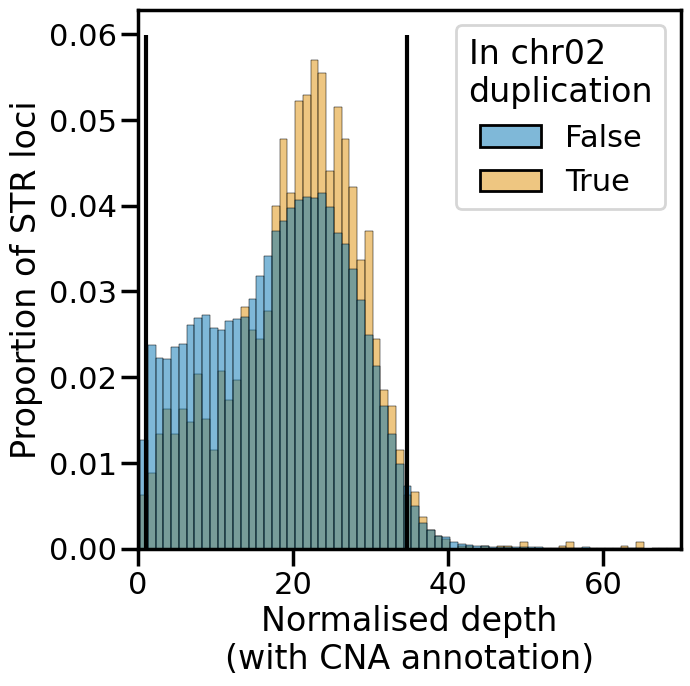

In [9]:
fig = plt.figure(figsize=(7, 7))

ax = sns.histplot(
    df_calls.query("depth_norm < 100").assign(depth_norm = lambda x: [i * .75 if j else i for i, j in zip(x["depth_norm"], x["in_dup"])]),
    x="depth_norm",
    hue="in_dup",
    palette="colorblind",
    discrete=True,
    stat="probability",
    common_norm=False
)

ax.vlines(x=[lower, upper], ymin=0, ymax=ax.get_ylim()[1], color="black")

_ = ax.set(
    xlim=(0, 70),
    xlabel="Normalised depth\n(with CNA annotation)",
    ylabel="Proportion of STR loci"
)

_ = ax.get_legend().set(title="In chr02\nduplication")

In [10]:
select = ["in_dup", "group", "depth_norm"]

df_nodup = df_calls[~df_calls["in_dup"]].reset_index(drop=True).assign(group="not in duplication").filter(select)
df_dup = df_calls[df_calls["in_dup"]].reset_index(drop=True).assign(group="in duplication\n(no CNA info)").filter(select)
df_dup_corrected = df_calls[df_calls["in_dup"]].reset_index(drop=True).assign(
    depth_norm = lambda x: x["depth_norm"] * .75, 
    group="in duplication\n(with CNA info)").filter(select)

df_plot = pd.concat([df_nodup, df_dup, df_dup_corrected])

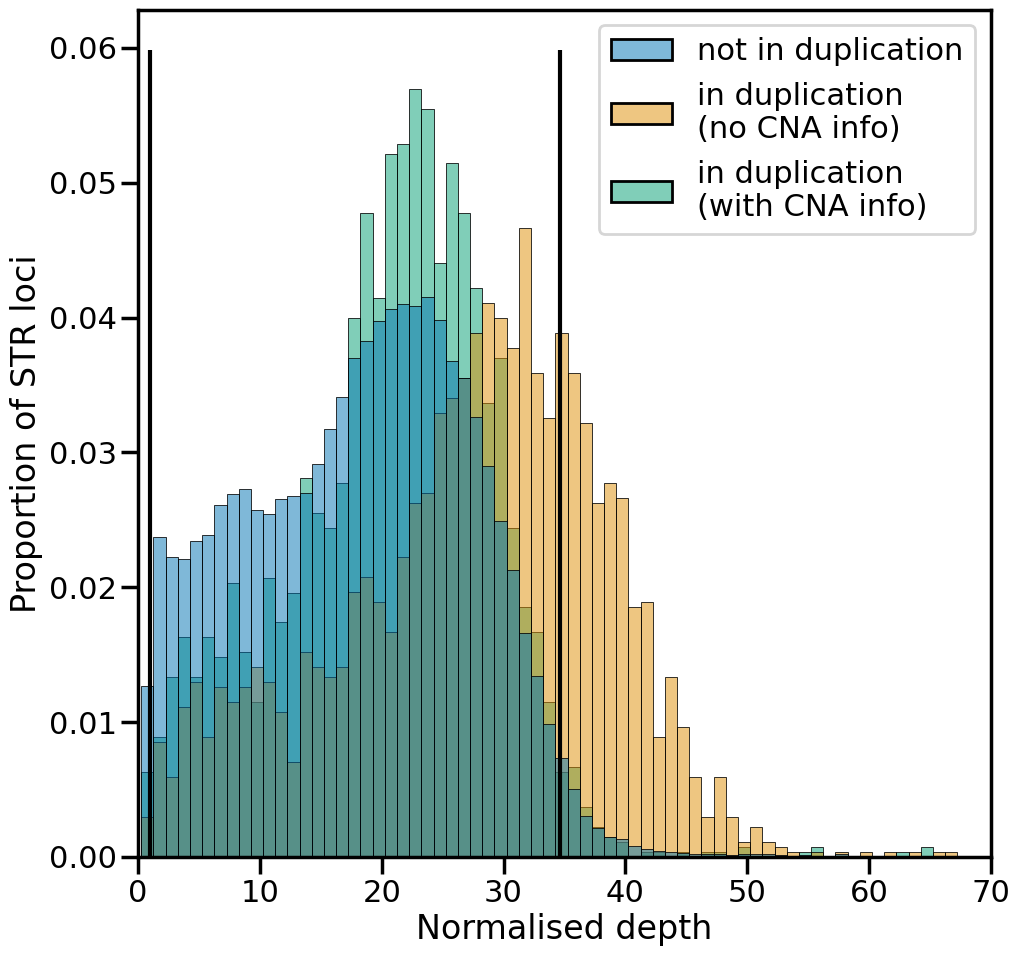

In [11]:
fig = plt.figure(figsize=(11, 11))

ax = sns.histplot(
    df_plot.query("depth_norm < 100"),
    x="depth_norm",
    hue="group",
    palette="colorblind",
    discrete=True,
    stat="probability",
    common_norm=False
)

ax.vlines(x=[lower, upper], ymin=0, ymax=ax.get_ylim()[1], color="black")

_ = ax.set(
    xlim=(0, 70),
    xlabel="Normalised depth",
    ylabel="Proportion of STR loci"
)

_ = ax.get_legend().set(title="")

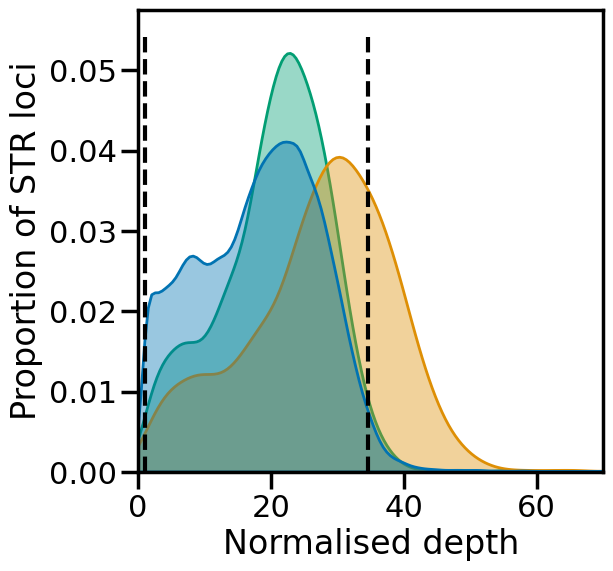

In [12]:
fig = plt.figure(figsize=(6, 6))

ax = sns.kdeplot(
    df_plot.query("depth_norm < 100"),
    x="depth_norm",
    hue="group",
    fill="group",
    palette="colorblind",
    common_norm=False,
    alpha=.4,
    legend=False
)

ax.vlines(x=[lower, upper], ymin=0, ymax=ax.get_ylim()[1], color="black", linestyle="--")

_ = ax.set(
    xlim=(0, 70),
    xlabel="Normalised depth",
    ylabel="Proportion of STR loci"
)
# legend = ax.get_legend()
# _ = legend.set(title="", bbox_to_anchor=(2, 1))
# legend.get_frame().set_alpha(1.)

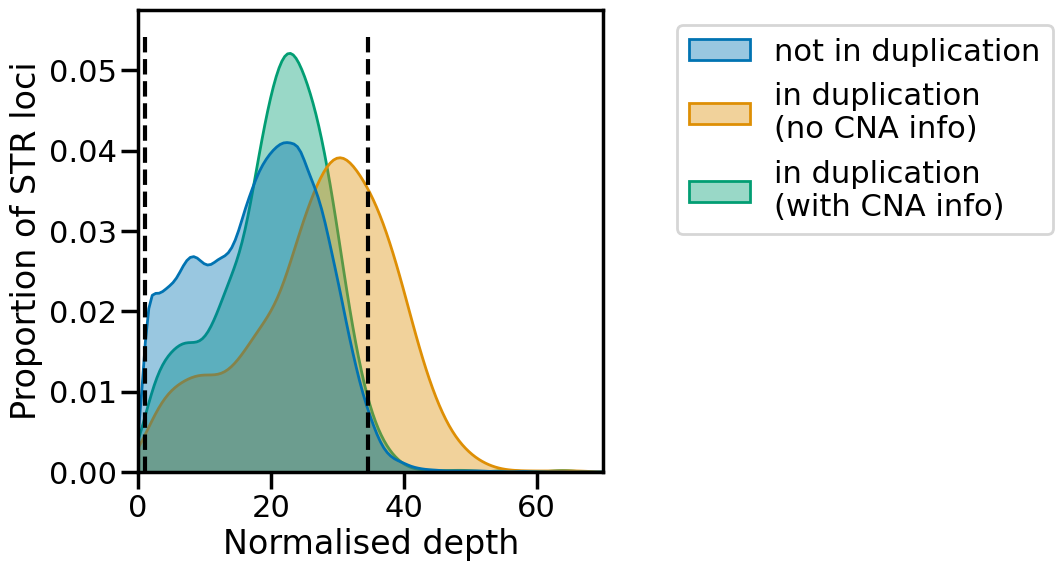

In [13]:
fig = plt.figure(figsize=(6, 6))

ax = sns.kdeplot(
    df_plot.query("depth_norm < 100"),
    x="depth_norm",
    hue="group",
    fill="group",
    palette="colorblind",
    common_norm=False,
    alpha=.4,
)

ax.vlines(x=[lower, upper], ymin=0, ymax=ax.get_ylim()[1], color="black", linestyle="--")

_ = ax.set(
    xlim=(0, 70),
    xlabel="Normalised depth",
    ylabel="Proportion of STR loci"
)
legend = ax.get_legend()
_ = legend.set(title="", bbox_to_anchor=(2, 1))
# legend.get_frame().set_alpha(1.)

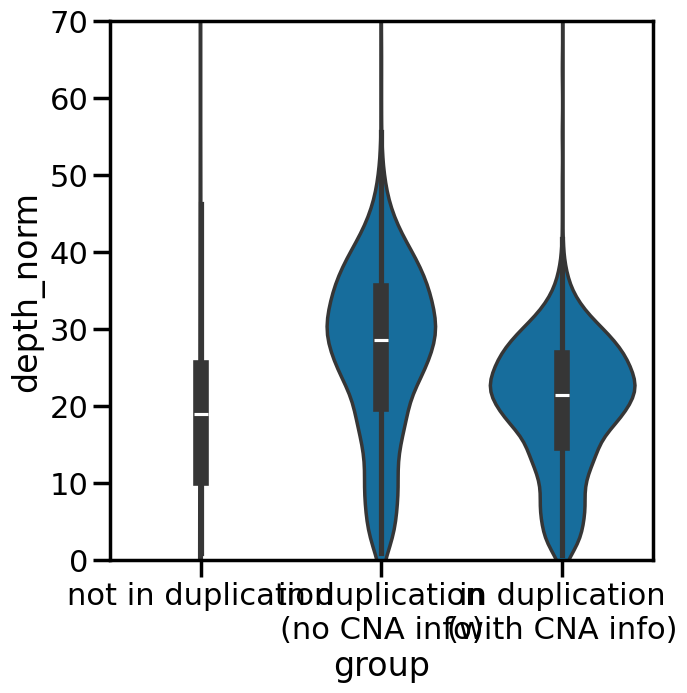

In [14]:
fig = plt.figure(figsize=(7, 7))

ax = sns.violinplot(
    df_plot,
    x="group",
    y="depth_norm",
    color=sns.color_palette("colorblind")[0]
)

# ax.vlines(x=[lower, upper], ymin=0, ymax=ax.get_ylim()[1], color="black")

_ = ax.set(
    ylim=(0, 70),
    # xlabel="Normalised depth\n(with CNA annotation)",
    # ylabel="Proportion of STR loci"
)

# _ = ax.get_legend().set(title="In chr02\nduplication")

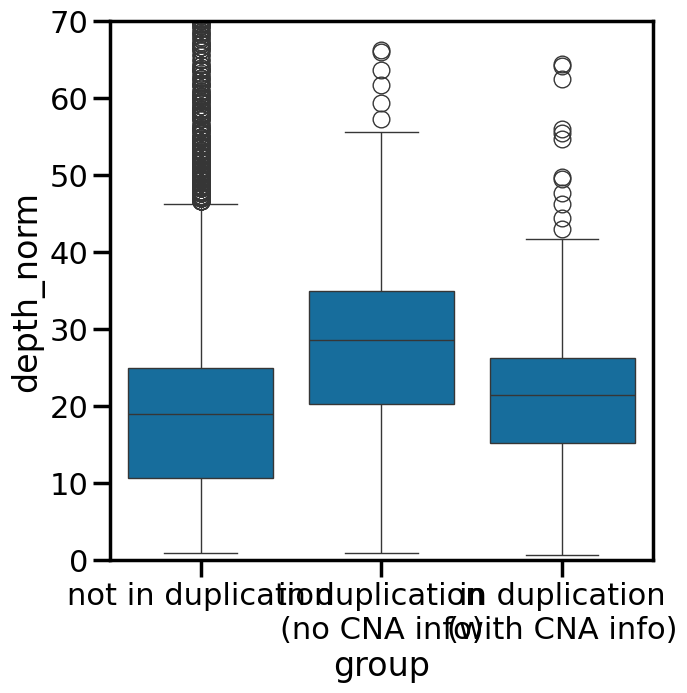

In [15]:
fig = plt.figure(figsize=(7, 7))

ax = sns.boxplot(
    df_plot,
    x="group",
    y="depth_norm",
    color=sns.color_palette("colorblind")[0]
)

_ = ax.set(
    ylim=(0, 70),
)


In [16]:
from scipy import stats

print(df_nodup["depth_norm"].mean(), df_dup["depth_norm"].mean(), df_dup_corrected["depth_norm"].mean())
print(df_nodup["depth_norm"].median(), df_dup["depth_norm"].median(), df_dup_corrected["depth_norm"].median())
print()
print(stats.ttest_ind(df_nodup["depth_norm"], df_dup["depth_norm"]))
print(stats.ttest_ind(df_nodup["depth_norm"], df_dup_corrected["depth_norm"]))
print(stats.ttest_ind(df_dup["depth_norm"], df_dup_corrected["depth_norm"]))
print()
print(stats.mannwhitneyu(df_nodup["depth_norm"], df_dup["depth_norm"]))
print(stats.mannwhitneyu(df_nodup["depth_norm"], df_dup_corrected["depth_norm"]))
print(stats.mannwhitneyu(df_dup["depth_norm"], df_dup_corrected["depth_norm"]))

18.84167862966114 27.29399432729066 20.470495745468
19.0 28.666666666666668 21.5

TtestResult(statistic=-9.71247589578443, pvalue=2.707611096356032e-22, df=153165.0)
TtestResult(statistic=-1.8721220401809315, pvalue=0.06119162543629854, df=153165.0)
TtestResult(statistic=24.981544459304956, pvalue=1.909790567114488e-130, df=5404.0)

MannwhitneyuResult(statistic=105731584.0, pvalue=0.0)
MannwhitneyuResult(statistic=173817650.5, pvalue=1.972341946458907e-38)
MannwhitneyuResult(statistic=5119037.0, pvalue=5.503716366074337e-144)
